---
author: Roel Smit
updated: December 12, 2025
---

# Arbeid

## Doelen

Nu we de microscopische grootheden van de moleculen hebben verbonden aan de macroscopische grootheden van het gas kunnen we de thermodynamica van het gas echt bestuderen met onze simulatie. In dit werkblad kijken we hoe de temperatuur en de druk veranderen onder invloed van een zuiger die het volume verandert. 

Eerst herhalen we de delen van de code die we nodig hebben:

- klasse voor het deeltje met bijbehorende functies
- variabelen en randcondities van de controle volume
- functies voor (een lijst) deeltjes

Daarna voegen we code toe voor de dynamiek van de zuiger:

- zuiger implementeren in volume en dynamische formules

En vervolgens:
- bestuderen van temperatuur en druk als functie van volume
- onderzoeken of we terug kunnen keren naar startcondities

In onderstaande animatie laten we het proces zien dat je gaat programmeren.

<!-- ```{iframe} 
YT van an

``` -->

## Laden van eerdere code

We beginnen weer met de noodzakelijke pakketten en de constanten. Daar voegen we nu een constante aan toe: de startsnelheid van de zuiger. 

```{exercise} Startwaardes
:label: ex-arbeid-01
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over. Let op dat de snelheid van de zuiger tien maal zo laag is als de startsnelheid van de deeltjes.
```

In [ ]:
# ruimte voor uitwerking

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit

BOX_SIZE_0 = 20                 # Hoogte en breedte startvolume
N = 40                         # Aantal deeltjes
V_0 = 2                       # Startsnelheid van deeltjes
RADIUS = 1                     # Straal van moleculen
DT = 0.1                         # Tijdstap om geen botsing te missen
V_PISTON_0 = -0.1 * V_0      # Startsnelheid van zuiger 
# (negatief betekent zowel links als rechts naar binnen gericht)

#your code/answer


Zoals altijd laden we de klasse voor de gasmoleculen en de functies voor hun onderlinge interactie:

In [ ]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0]-p2.r[0]
    dy = p1.r[1]-p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

Het volume en de randvoorwaarden zullen we moeten aanpassen aan onze simulatie met bewegende zuiger: Het volume zal nu niet meer altijd een vierkant zijn. 

```{figure} ../../Figures/zuiger.png
:width: 50%

De simulatie bestaat uit een volume met links en rechts een bewegende wand: de zuiger.
```

Laten we aannemen dat de zuiger altijd in de horizontale richting verplaatst en het volume symmetrisch houdt ten opzichte van de oorsprong, d.w.z. er is een zuiger aan de linker wand die een tegengestelde verplaatsing heeft aan die in de rechter wand. 

We maken eerst een aantal variabelen aan die bij het volume horen:

In [ ]:
box_height = BOX_SIZE_0     # hoogte van beheersvolume
box_length = BOX_SIZE_0     # breedte van beheersvolume
impulse_outward = 0.0       # totale stoot van deeltjes naar buiten gericht
pressure = 0.0              # druk in beheersvolume
v_piston = V_PISTON_0       # huidige snelheid van zuiger 
work = 0.0                  # arbeid uitgevoerd door gas

De functies die bij het volume en de randvoorwaarden horen moeten we een klein beetje aanpassen, zodat we niet langer uitgaan van de constante waarde van de lengte en hoogte. Om de variabelen zoals `box_height` en `box_length` die we hierboven gedefinieerd hebben, later in functies te gebruiken, moeten we ze telkens oproepen met het keyword `global`. Dit is hieronder uitgewerkt. 

In [ ]:
def top_down_collision(particle: ParticleClass):
    """ botsingen met wanden onder en boven controleren en totale stoot bepalen """
    global impulse_outward, box_height
    if abs(particle.r[1]) + particle.R > box_height / 2:
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1
    
def left_right_collision(particle: ParticleClass):
    """ botsingen met wanden links en rechts controleren en totale stoot bepalen """
    global impulse_outward, box_length
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        impulse_outward += abs(particle.momentum[0]) * 2
        particle.v[0] *= -1

En dan laden we ook alle functies die over de gehele lijst met deeltjes werken, waarbij een paar kleine aanpassingen nodig zijn vanwege de splitsing in het botsen met de wanden. Ook hier roepen we een aantal variabelen met `global` aan.

```{exercise} Startfuncties
:label: ex-arbeid-02
Pas de code voor de temperatuur weer aan naar de code die je in de vorige werkbladen hebt gebruikt.
```

In [ ]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    global box_length, box_height
    particles.clear()
    for _ in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        x = np.random.uniform(-box_length/2 + RADIUS, box_length/2 - RADIUS)
        y = np.random.uniform(-box_height/2 + RADIUS, box_height/2 - RADIUS)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=[x, y], R=RADIUS))
    
def temperature(particles) -> float:
    """
    Bereken de temperatuur van het gas op basis van de kinetische energie
    van alle deeltjes in het volume.
    """
    if len(particles) == 0:
        return 0.0
    
    kB = 1.38e-23  # J/K
    total_kin_energy = sum(p.kin_energy for p in particles)
    T = (2 * total_kin_energy) / (len(particles) * 2 * kB) 
    return T

        
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward, box_height, box_length   # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    pressure = 0.95 * pressure + 0.05 * impulse_outward / ((2 * box_length + 2 * box_height) * DT) 

def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  


## Implementeren (symmetrische) zuiger



Voordat we nog meer veranderingen aan de code doorvoeren, moeten we eerst controleren of alles nog werkt. Onderstaande functie is een beetje aangepast ten opzichte van vorige werkbladen, omdat we merkten dat de vorm van de pijlen wel eens de mist in ging bij een heel andere keuze voor eenheden in de constanten.

In [ ]:
particles = []
create_particles(particles)
for i in range(100):
    take_time_step(particles)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0]*DT*30, p.v[1]*DT*30, width=.2*RADIUS,
              head_width=RADIUS, head_length=RADIUS, color='red')
plt.show()

Nu implementeren we de zuiger door het toegestane gebied voor de gasdeeltjes bij elke tijdstap te verkleinen met een stap $2v_{\text{piston}}dt$. De factor $2$ is opgenomen omdat zowel de linker en de rechter wand een zuigerwand zijn.  

In [ ]:
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    global box_length, v_piston
    box_length += 2 * v_piston * DT # zowel links als rechts zuiger
    for p in particles:
        p.update_position()
    handle_walls(particles)  
    handle_collisions(particles)

Hieronder draaien we een kleine simulatie om te kijken of we de box kleiner zien worden en vervolgens te bestuderen hoe de temperatuur zich gedraagt als functie van het oppervlak/volume. 

```{warning} 
Verwijder de cel outputs alvorens te pushen naar GitHub! Het filmpje neemt nogal wat geheugen in!
```


In [ ]:
# Deel van de animated simulatie
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_aspect('equal')
dot, = ax.plot([], [], 'ro', ms=14);

def init():
    dot.set_data([], [])
    return dot,


# we kiezen het aantal datapunten zodat het volume tot 1/3 van het begin volume reduceert
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))

particles = []
volumes = np.zeros(num_steps, dtype=float)
temperatures = np.zeros(num_steps, dtype=float)

box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0
create_particles(particles)     # resetten deeltjes     

def update(frame):
    take_time_step(particles)
    dot.set_data([p.r[0] for p in particles], [p.r[1] for p in particles])
    volumes[i] = box_length * box_height
    temperatures[i] = temperature(particles)
    return dot,
    
ani = FuncAnimation(fig, update, frames=int(num_steps/2), init_func=init, blit=True, interval=50)
HTML(ani.to_jshtml())



In [ ]:
# we kiezen het aantal datapunten zodat het volume tot 1/3 van het begin volume reduceert
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))

particles = []
volumes = np.zeros(num_steps, dtype=float)
temperatures = np.zeros(num_steps, dtype=float)

box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0
create_particles(particles)     # resetten deeltjes     

for i in range(num_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    temperatures[i] = temperature(particles)

temperatures = np.asarray(temperatures)

plt.figure()
plt.xlabel('Volume')
plt.ylabel('Temperature')

plt.plot(volumes, temperatures, '-r')
plt.show()

Dit kan niet kloppen. Hier zien we dat de temperatuur vrijwel constant is (let op de vermenigvuldigingsfactor vermeld aan de bovenkant van de verticale as). Maar de zuiger voert arbeid uit, op baiss van de wet van behoud van energie betekent zou de temperatuur moet veranderen!

Om het model kloppend te maken moeten we kijken naar de botsing van de deeltjes met de wand. In de vorige werkbladen stonden de wanden stil en veranderde de snelheid van de deeltjes alleen van teken in de component loodrecht op de wand. Nu dat de wanden een zuiger zijn en snelheid hebben, moeten we daarvoor corrigeren.

De snelheid van de deeltjes klapt nog steeds om van teken in het referentiestelsel van de wand, maar omdat de wand beweegt ten opzichte van het volume met snelheid $v_{\text{piston}}$, wordt de juiste functie:

In [ ]:
def left_right_collision(particle: ParticleClass):
    """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
    global box_length, v_piston, impulse_outward
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        piston_velocity = np.sign(particle.r[0]) * v_piston
        relative_velocity = particle.v[0] - piston_velocity           # stelsel zuiger
        particle.v[0] = -relative_velocity + piston_velocity          # stelsel waarnemer
        impulse_outward += 2 * particle.m * abs(relative_velocity)    # stoot gevoeld door zuiger

Nu kunnen we de simulatie opnieuw uitvoeren:


```{exercise} Getallen en eenheden
:label: ex-arbeid-03
Pas de code aan, zodat de getalwaardes op de assen kloppen en de juiste eenheden in de titels van de assen vermeld staan.

Check eventueel ook of de deeltjes in je eerdere animatie ook sneller bewegen!
```

In [ ]:
# Reset parameters
box_length = BOX_SIZE_0
v_piston = V_PISTON_0
particles = []
create_particles(particles)

# Aantal stappen zodat volume tot 1/3 wordt gereduceerd
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))

volumes = np.zeros(num_steps, dtype=float)
temperatures = np.zeros(num_steps, dtype=float)

# Simulatie: tijdstappen met bewegende zuiger
for i in range(num_steps):
    take_time_step(particles)                  # update posities en botsingen
    volumes[i] = box_length * box_height      # bereken volume
    temperatures[i] = temperature(particles)  # bereken temperatuur

# Plot Volume vs Temperatuur
plt.figure()
plt.xlabel('Volume (m²)')
plt.ylabel('Temperatuur (K)')
plt.title('Temperatuur van gas bij samenpersing door zuiger')
plt.plot(volumes, temperatures, '-r')
plt.grid(True)
plt.show()


We zien nu een heel duidelijke afhankelijkheid van de temperatuur op het volume, zoals we ook verwachten vanwege de wet van behoud van energie. Een volgende logische stap is of deze grafiek ook daadwerkelijk overeenkomt met onze verwachting, maar daarvoor is het waardevol om ook informatie te halen uit de andere grootheden. 

```{exercise} Druksimulatie
:label: ex-arbeid-04
Maak een simulatie waarin niet de temperatuur, maar de druk als functie van het volume wordt geplot. Gebruik dezelfde waarden voor het aantal tijdstappen en het volume, zoals in de startcode die je hieronder al ziet. Let ook nu op getallen en eenheden.
```

In [ ]:
# Aantal tijdstappen en initiële instellingen
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))
particles = []
volumes = np.zeros(num_steps, dtype=float)
pressures = np.zeros(num_steps, dtype=float)

pressure = 0.0
box_length = BOX_SIZE_0         # reset zuiger
v_piston = V_PISTON_0
create_particles(particles)     # reset deeltjes

# Simulatie: druk bijhouden
for i in range(num_steps):
    take_time_step(particles)      # update posities, botsingen en druk
    volumes[i] = box_length * box_height
    pressures[i] = pressure        # druk zoals berekend in handle_walls()

# Plot Volume vs Druk
plt.figure()
plt.xlabel('Volume (m²)')
plt.ylabel('Druk (Pa)')
plt.title('Druk van gas bij samenpersing door zuiger')
plt.plot(volumes, pressures, '-b')
plt.grid(True)
plt.show()


Als je simulatie klopt heeft deze grafiek de vorm van een machtsfunctie met een negatieve exponent. 

```{exercise} Exponent
:label: ex-arbeid-05
Leg uit welke factor je hier verwacht voor de exponent op basis van de theorie van het boek.
```

```{solution} ex-arbeid-05
Voor een 2D gas geldt dat de druk bij adiabatische compressie afneemt volgens een machtswet. Omdat elk deeltje twee vrijheidsgraden heeft, is de adiabatische index γ gelijk aan 2. Daarom verwachten we dat de druk afneemt met het volume volgens 𝑃∝𝑉^−2


```

```{exercise}
:label: ex-arbeid-06
Bepaal met behulp van een fit wat het resultaat van de simulatie voor de machtsterm is. 

Let op dat je goed beginwaardes meegeeft bij de code `p0=...`, anders dan breekt de fitfunctie af, omdat er geen goed antwoord gevonden kan worden.

Daarnaast kun je gebruik maken van bounds: `bounds=((a_min, n_min),(a_max, n_max))`. Alleen de waarden hiertussen worden beschouwd.
```

In [ ]:
from scipy.optimize import curve_fit

# power-law functie
def power_law(vol, a, n):
    return a * vol**n

# Beginwaarden en grenzen voor de fit
a0 = pressures[0]        # startdruk als initiele amplitude
n0 = -1.0                # verwachtte negatieve exponent
bounds = ((0, -5), (np.inf, 0))  # amplitude positief, exponent negatief

# Fit uitvoeren
params, covariance = curve_fit(power_law, volumes, pressures, p0=[a0, n0], bounds=bounds)
a_fit, n_fit = params

print(f"Fit resultaten: a = {a_fit:.3f}, n = {n_fit:.3f}")


Als je de simulatie een aantal keer uitvoert, zie je dat er een structureel verschil zit tussen de waarde die je verwacht en de waarde die je uit de fit krijgt.

```{exercise} Afwijking
:label: ex-arbeid-07
Wat is de belangrijkste reden voor deze afwijking? Geef een methode van aanpak waarmee je voor deze simulatie kan verifiëren of dit inderdaad de juiste is. (Je hoeft dit niet uit te voeren, maar het mag natuurlijk wel)
```

```{solution} reason_power
Jouw antwoord hier...
#your code/answer
```

In [ ]:
# Ruimte voorverificatie

#De afwijking komt doordat de zuiger niet langzaam genoeg beweegt en het gas daardoor niet in evenwicht blijft,
#waardoor de druk iets hoger uitkomt dan theoretisch. 
#Dit kun je controleren door de simulatie met een veel lagere zuigersnelheid uit te voeren:
#als de fit exponent dichter bij de verwachte waarde komt, bevestigt dat dat de beweging van de zuiger de oorzaak is.


## Eerste hoofdwet
Een goede controle voor ons simulatie is te onderzoeken of deze voldoet aan de eerste hoofdwet van de thermodynamica. 

Omdat er (nog) geen warmte wordt uitgewisseld, moeten we alleen de hoeveelheid arbeid bepalen. De arbeid wordt geleverd door de zuiger(s) op de deeltjes. Dus in de functie waar we de botsingen van de deeltjes met de wand behandelen, kunnen we ook de verrichte arbeid bepalen. De arbeid wordt gegeven\ door:

$$
    W = \int_1^2 P dV
$$

Hier staan de $1$ voor de begintoestand en de $2$ voor de eindtoestand van het proces. In de differentiaalvorm wordt dit geschreven als:

$$
    \delta W = P dV
$$

Zoals dat in het boek gebeurt, kiezen we voor de notatie met $\delta W$ in plaats van $dW$, om aan te geven dat deze integraal afhankelijk is van het gekozen proces en niet alleen van het begin- en eindpunt. Voor ons experiment, waar het volume niet geleidelijk maar in stapjes verandert, kan je de hoeveelheid arbeid per tijdstip dus herschrijven tot:

$$ 
    \Delta W = P \Delta V \stackrel{2D}{=} P \Delta A = P h v_{\text{piston}}  \Delta t = \frac{\Delta p}{h \Delta t} h v_{\text{piston}} \Delta t = v_{\text{piston}}\Delta p
$$

waarin $h$ de hoogte is van de zuiger.

Dit betekent dat we de arbeid per tijdstap in onze code kunnen bepalen op hetzelfde moment dat we de druk bepalen met behulp van de gezamenlijke stoot van de moleculen. Daarvoor moeten we de code voor de functie `left_right_collision` nogmaals aanpassen:

In [ ]:
def left_right_collision(particle: ParticleClass):
    """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
    global box_length, v_piston, impulse_outward, work
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        piston_velocity = np.sign(particle.r[0]) * v_piston
        relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
        particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
        impulse_outward += 2 * particle.m * abs(relative_velocity)
        work += 2 * particle.m * relative_velocity * piston_velocity

Voordat we een simulatie draaien is het goed even stil te staan en na te denken. Net als bij een experiment in het lab doorlopen we bewust de onderzoekscyclus. We moeten daarvoor eerst een hypothese opstellen en daarna pas de simulatie uitvoeren. 

```{exercise} Eerste Hoofdwet
:label: ex-arbeid-08
Welke twee grootheden kan je nu tegen elkaar uitzetten om te valideren of de simulatie aan de eerste hoofdwet voldoet? En welke grafiek verwacht je dan dat daar uitkomt?
```

```{solution} ex-arbeid-08
Je kunt de totale verrichte arbeid 𝑊 tegen de verandering in kinetische energie ΔE_kin van het gas uitzetten. Als de simulatie klopt met de eerste hoofdwet, verwacht je een rechte lijn met een helling van 1, omdat alle arbeid die de zuiger verricht volledig omgezet wordt in kinetische energie van de deeltjes.
```

```{exercise} Hoofdwet gecontroleerd
:label: ex-arbeid-09
Stel de code op om deze grafiek te produceren. Neem wederom 1000 tijdstappen met de standaard snelheid voor de zuiger en vergelijk het resultaat met je hypothese.
```

In [ ]:
# Aantal tijdstappen
num_steps = 1000

# Reset de deeltjes, box en arbeid
particles = []
box_length = BOX_SIZE_0
v_piston = V_PISTON_0
work = 0.0
create_particles(particles)

# kinetische energie bij elke stap
kin_energy = np.zeros(num_steps, dtype=float)
work_history = np.zeros(num_steps, dtype=float)

for i in range(num_steps):
    take_time_step(particles)
    kin_energy[i] = sum(p.kin_energy for p in particles)
    work_history[i] = work

# Verandering in kinetische energie ten opzichte van start
delta_kin_energy = kin_energy - kin_energy[0]

# Plotten van arbeid tegen Ekin
plt.figure()
plt.plot(work_history, delta_kin_energy, '-b')
plt.xlabel('Arbeid door zuiger W (J)')
plt.ylabel('Δ kinetische energie gas (J)')
plt.title('Validatie eerste hoofdwet van de thermodynamica')
plt.grid(True)    
plt.show()



## Reversibiliteit
Als laatste onderdeel van dit werkblad maken we een eenvoudige cyclus. We comprimeren het volume gedurende 1000 tijdstappen en keren daarna in 1000 gelijke tijdstappen terug naar het startvolume. 

```{exercise} Terugkeren
:label: ex-arbeid-10

Een deel van de vorige code kan hergebruikt worden, maar halverwege moeten de richting van de zuigers omdraaien.

Vul de code aan en voor de volledige simulatie uit. Gebruik een verschillende kleur voor de grafiek tijdens de compressie en de decompressie.
```

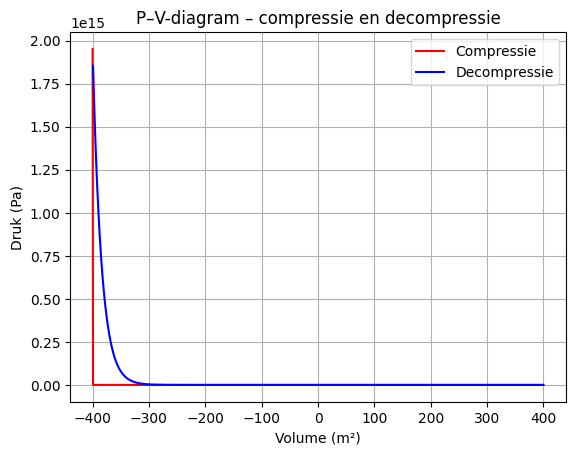

In [192]:
num_steps = 1000  # compressie
particles = []
pressure = 0.0
work = 0.0
box_length = BOX_SIZE_0
v_piston = V_PISTON_0
create_particles(particles)

pressures = np.zeros(2*num_steps, dtype=float)
volumes = np.zeros(2*num_steps, dtype=float)
work_history = np.zeros(2*num_steps, dtype=float)

# compressie
for i in range(num_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    work_history[i] = work

# decompressie
v_piston = -V_PISTON_0

for i in range(num_steps, 2*num_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    work_history[i] = work

# Plotten
plt.figure()
plt.plot(volumes[:num_steps], pressures[:num_steps], '-r', label='Compressie')
plt.plot(volumes[num_steps:], pressures[num_steps:], '-b', label='Decompressie')
plt.xlabel('Volume (m²)')
plt.ylabel('Druk (Pa)')
plt.title('P–V-diagram – compressie en decompressie')
plt.legend()
plt.grid(True)
plt.show()


```{exercise} Afhankelijk van snelheid
:label: ex-arbeid-11
Herhaal deze simulatie maar nu met een 5 keer zo hoge snelheid voor de zuiger in beide richtingen. Je hebt dus 5x minder stappen nodig.

Pas het aantal tijdstappen aan tot 400, zodat de zuiger in één 'slag' dezelfde afstand aflegt. 
```

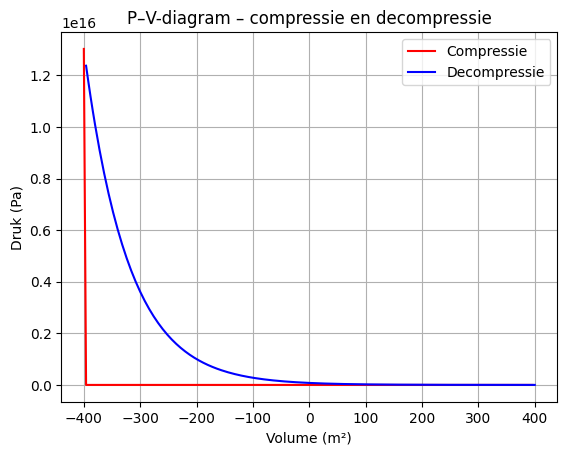

In [ ]:
particles = []
pressure = 0.0
work = 0.0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = 5 * V_PISTON_0
create_particles(particles)     # resetten deeltjes

num_steps = 200  

pressures = np.zeros(2*num_steps, dtype=float)
volumes = np.zeros(2*num_steps, dtype=float)
work_history = np.zeros(2*num_steps, dtype=float)

# compressie
for i in range(num_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    work_history[i] = work

# decompressie
v_piston = -5 * V_PISTON_0

for i in range(num_steps, 2*num_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    work_history[i] = work

# Plotten
plt.figure()
plt.plot(volumes[:num_steps], pressures[:num_steps], '-r', label='Compressie')
plt.plot(volumes[num_steps:], pressures[num_steps:], '-b', label='Decompressie')
plt.xlabel('Volume (m²)')
plt.ylabel('Druk (Pa)')
plt.title('P–V-diagram – compressie en decompressie')
plt.legend()
plt.grid(True)
plt.show()


In deze laatste simulatie zie je (bij een correcte code) dat nog altijd netjes wordt voldaan aan de eerste hoofdwet. Ondanks dat, zie je dat het systeem niet terugkeert naar de begintoestand. In het boek wordt dit omschreven in het deel over 'quasi-equilibrium': Processen moeten voldoende traag plaatsvinden zodat er zich een evenwicht kan vormen binnen het gas. Als processen te snel plaatsvinden is er geen sprake van equilibrium en kun je de macroscopische thermodynamische formules niet langer gebruiken.

```{exercise} Getallen en eenheden hh
:label: ex-arbeid-12
Zorg ervoor dat er in de grafiek hierboven daadwerkelijk SI-eenheden op de assen staan, als je voor je code andere eenheden hebt gekozen. Bekijk ook wat de snelheid van de zuiger in SI-eenheden is. De kwaliteit van onze simulaties is onvoldoende gedetailleerd om echt uitspraken te kunnen doen over non-equilibrium processen, maar het antwoord laat zien dat we ons in het laboratorium niet direct zorgen hoeven maken.
```

```{exercise}
Maak je notebook leeg (clear output) en push je werk naar GitHub. Kies of je door gaat met de extra opdrachten voor een 'excellent' beoordeling.
```

```{exercise} 🌶 Uitbreiding
In bovenstaande simulatie hebben de twee zuigers een tegengestelde beweging. Maak nu een nieuwe simulatie, waarbij de twee zuigers in dezelfde richting bewegen. Dan verandert het oppervlak van het volume dus niet. (Dit kan in een nieuw werkblad, als je dat fijner vindt)

- Meet de temperatuur van het gas als functie van de verplaatsing van de zuigers. Beweeg de zuigers minimaal over de halve lengte van het volume. 
- Varieer de snelheid van de zuigers en de starttemperatuur van het gas en onderzoek de resultaten.
- Verklaar het gedrag. Doe dit zowel op een microscopisch niveau (met stuiterende balletjes met een impuls en een energie) als op een macroscopisch niveau (met druk, volume en temperatuur)
```